In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats as stats
import os

from estimators import offline_MIP
from estimators import online_MIP


'NuriaJrFiltered' : [[42.92, 0.327], [99, 0]],
'NadiaLateFilteredDownsampled' : [[42.77, 0.475], [95, 1]],
'NadiaEarlyFilteredDownsampled' : [[40.81, 1.145], [88, 1]],
'NuriaJrFilteredT1' : [[46.13, 0.396], [17, 1]],
'NadiaLateFilteredDownsampledT1' : [[42.23, 0.460], [19, 5]],
'NadiaEarlyFilteredDownsampledT1' : [[42.78, 0.583], [15, 1]],


Text(0.5, 0, 'max bin above baseline / ADC')

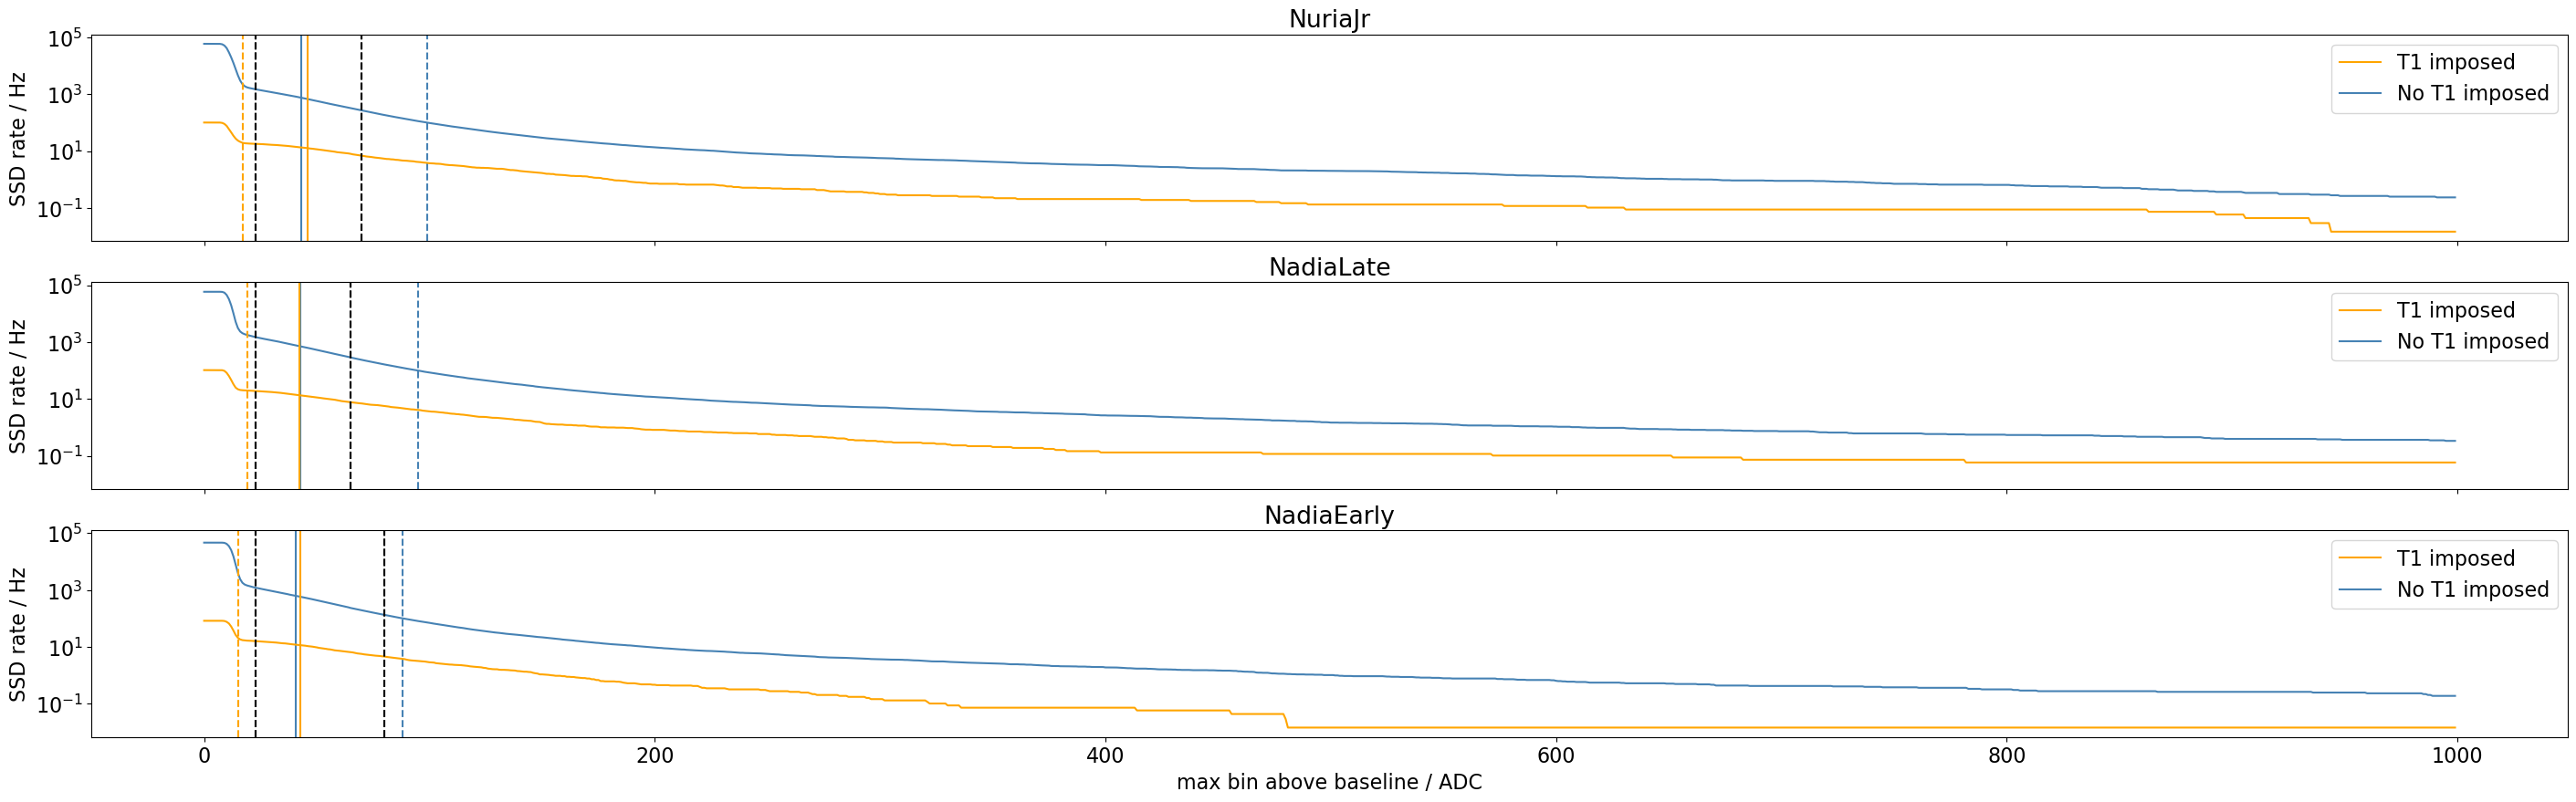

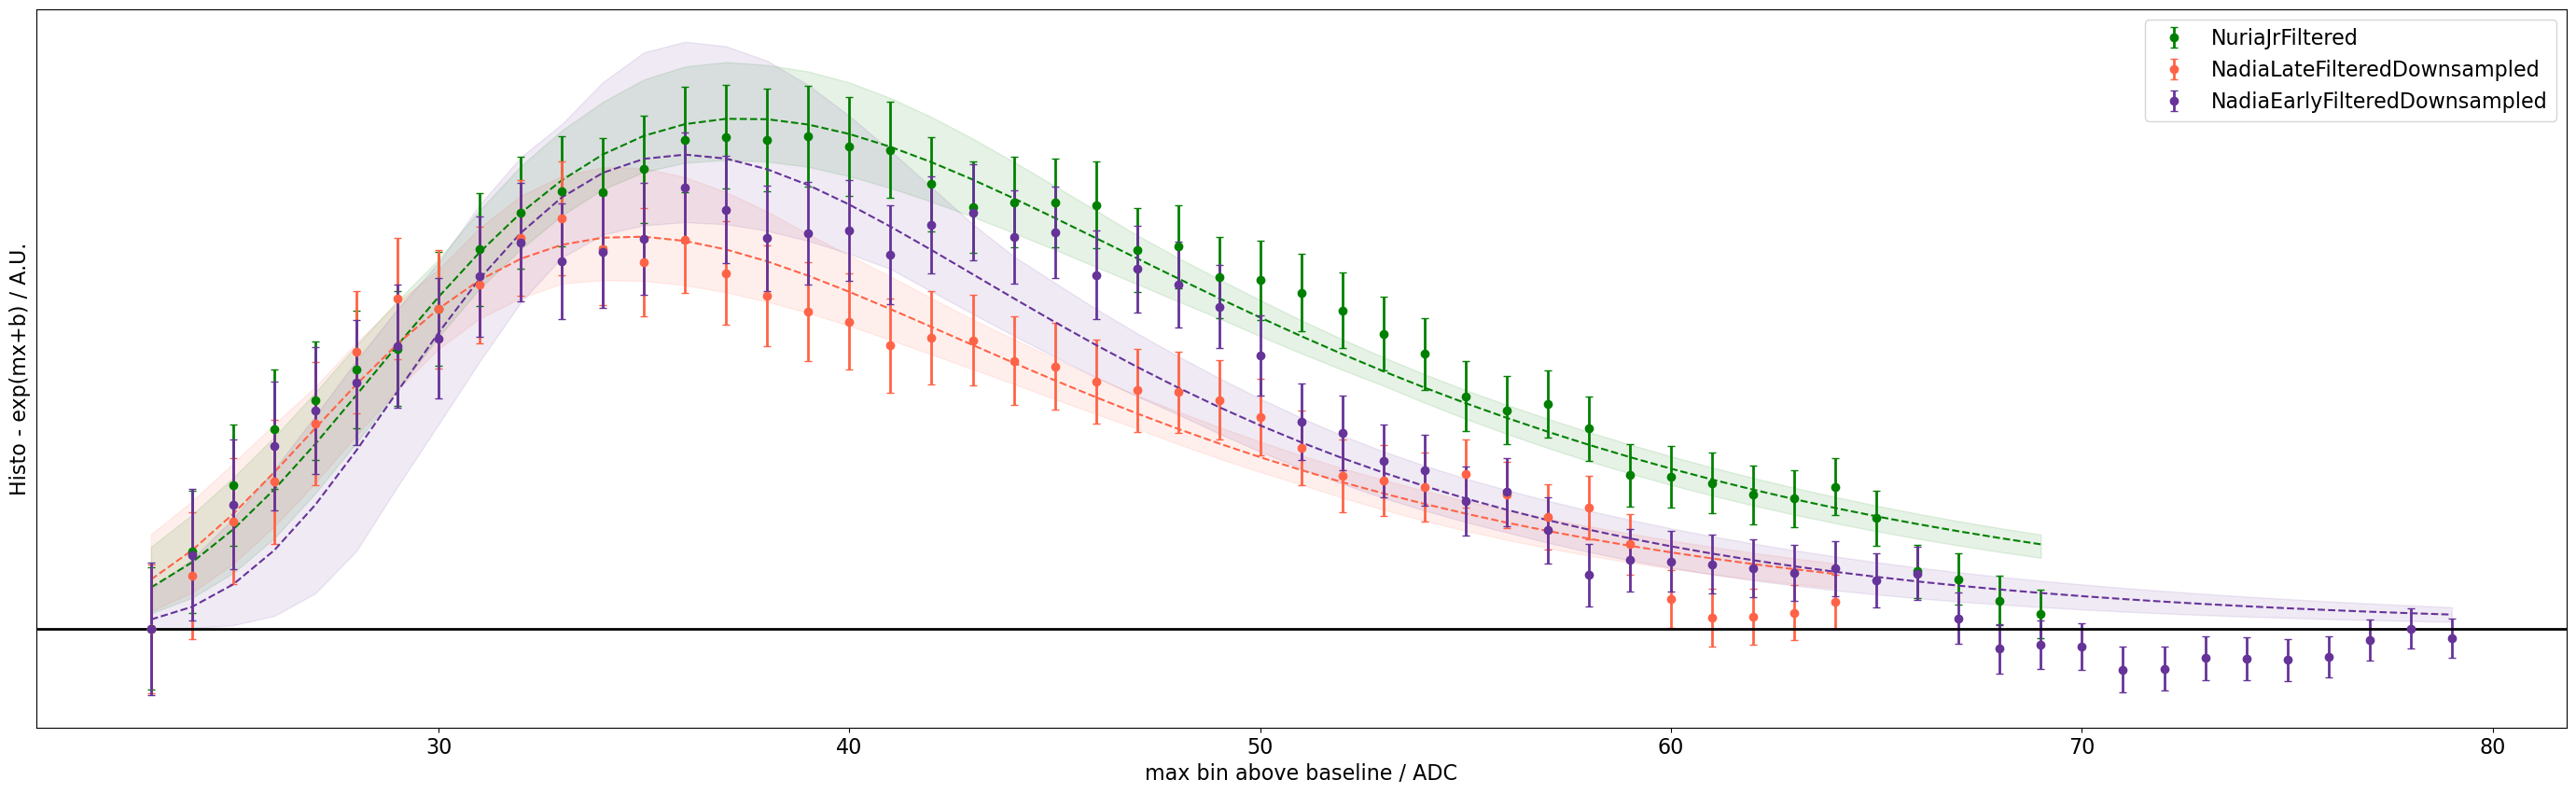

In [3]:
data_path = "/cr/tempdata01/filip/SSDCalib/"
plt.rcParams["figure.figsize"] = [35, 10]
plt.rcParams["font.size"] = 16
fig, ax = plt.subplots(3, 1, sharex = True, sharey = True)
fig, ax0 = plt.subplots()

offline_T1, offline_noT1 = {}, {}
color = ['green', '', 'red', 'blue']

def exp_background(x0, m, x, b):
    return np.exp(m * (x-x0) + b)

for T1 in ["", "T1"]:
    for i, station in enumerate(os.listdir(f"{data_path}/UubRates{T1}")):
        
        if station == "NuriaJrFiltered":
            x_min, x_max = (23, 70)
        elif station == ".PeruFiltered":
            x_min, x_max = (12, 26)
            continue
        elif station == "NadiaLateFilteredDownsampled":
            x_min, x_max = 23, 65
        elif station == "NadiaEarlyFilteredDownsampled":
            x_min, x_max = 23, 80

        ax[i].set_title(station.replace("Filtered","").replace("Downsampled",""))

        if T1 == "T1":
            color="orange"
            label="T1 imposed"
        else:
            color="steelblue"
            # label="No T1 imposed"
            label=None

        data_dir = f"{data_path}/UubRates{T1}/{station}/"

        rates = np.zeros(1000)

        for file_id in range(1, len(os.listdir(data_dir))):
            rates += np.loadtxt(data_dir + f"randoms{file_id:04d}.dat")

        station_time = file_id * 8.33e-9 * 2048 * 5000
        rates /= station_time
        
        ax[i].plot(range(1000), rates, c = color, label = label)


        # x_min, x_max = np.argmax(np.diff(np.diff(rates))) + 6, 401
        # residuals = np.array([-1])

        # if T1 == "T1":
        #     while np.any(residuals < 0) and x_max - x_min > 20:
        #         x_max -= 1

        #         m, b = (np.log(rates[x_max]) - np.log(rates[x_min])) / (x_max - x_min), np.log(rates[x_min])
        #         residuals = rates[x_min:x_max+1] - exp_background(x_min, m, range(x_min, x_max+1), b)

        #     while np.all(residuals >= 0):
        #         x_min -= 1

        #         m, b = (np.log(rates[x_max]) - np.log(rates[x_min])) / (x_max - x_min), np.log(rates[x_min])
        #         residuals = rates[x_min:x_max+1] - exp_background(x_min, m, range(x_min, x_max+1), b)
        # else:
        #     x_max = 100

        mu, sigma = offline_MIP(x_min, x_max, rates, station, ax0 if T1 else None)
        eta, chi = online_MIP(20 if T1 else 100, rates, station_time)
        ax[i].axvline(eta, c=color, ls='--')
        ax[i].axvline(mu, c=color)

        print(f"'{station}{T1}' : [[{mu:.2f}, {sigma:.3f}], [{eta}, {chi}]],")

        ax[i].axvline(x_min, c='k',ls='--')
        ax[i].axvline(x_max, c='k', ls='--')
        ax[i].set_yscale('log')
        # ax[i].set_xlim(0, 200)

ax0.legend()
ax0.set_yticks([])
ax0.set_ylabel("Histo - exp(mx+b) / A.U.")
ax0.set_xlabel("max bin above baseline / ADC")
ax0.axhline(0, c='k', lw=2)

for axis in ax:
    axis.set_ylabel("SSD rate / Hz")
    axis.plot([],[],c='steelblue',label='No T1 imposed')
    # axis.plot([],[],c='orange',label='T1 imposed')
    axis.legend()

ax[-1].set_xlabel("max bin above baseline / ADC")

In [6]:
# results copied from above
MIPs = {
'NuriaJrFiltered' : [[42.92, 0.327], [99, 0]],
'NadiaLateFilteredDownsampled' : [[42.77, 0.475], [95, 1]],
'NadiaEarlyFilteredDownsampled' : [[40.81, 1.145], [88, 1]],
'NuriaJrFilteredT1' : [[46.13, 0.396], [17, 1]],
'NadiaLateFilteredDownsampledT1' : [[42.23, 0.460], [19, 5]],
'NadiaEarlyFilteredDownsampledT1' : [[42.78, 0.583], [15, 1]],
}

NuriaJrFiltered 2.31 0.018
NadiaLateFilteredDownsampled 2.22 0.034
NadiaEarlyFilteredDownsampled 2.16 0.065
NuriaJrFilteredT1 0.37 0.022
NadiaLateFilteredDownsampledT1 0.45 0.119
NadiaEarlyFilteredDownsampledT1 0.35 0.024


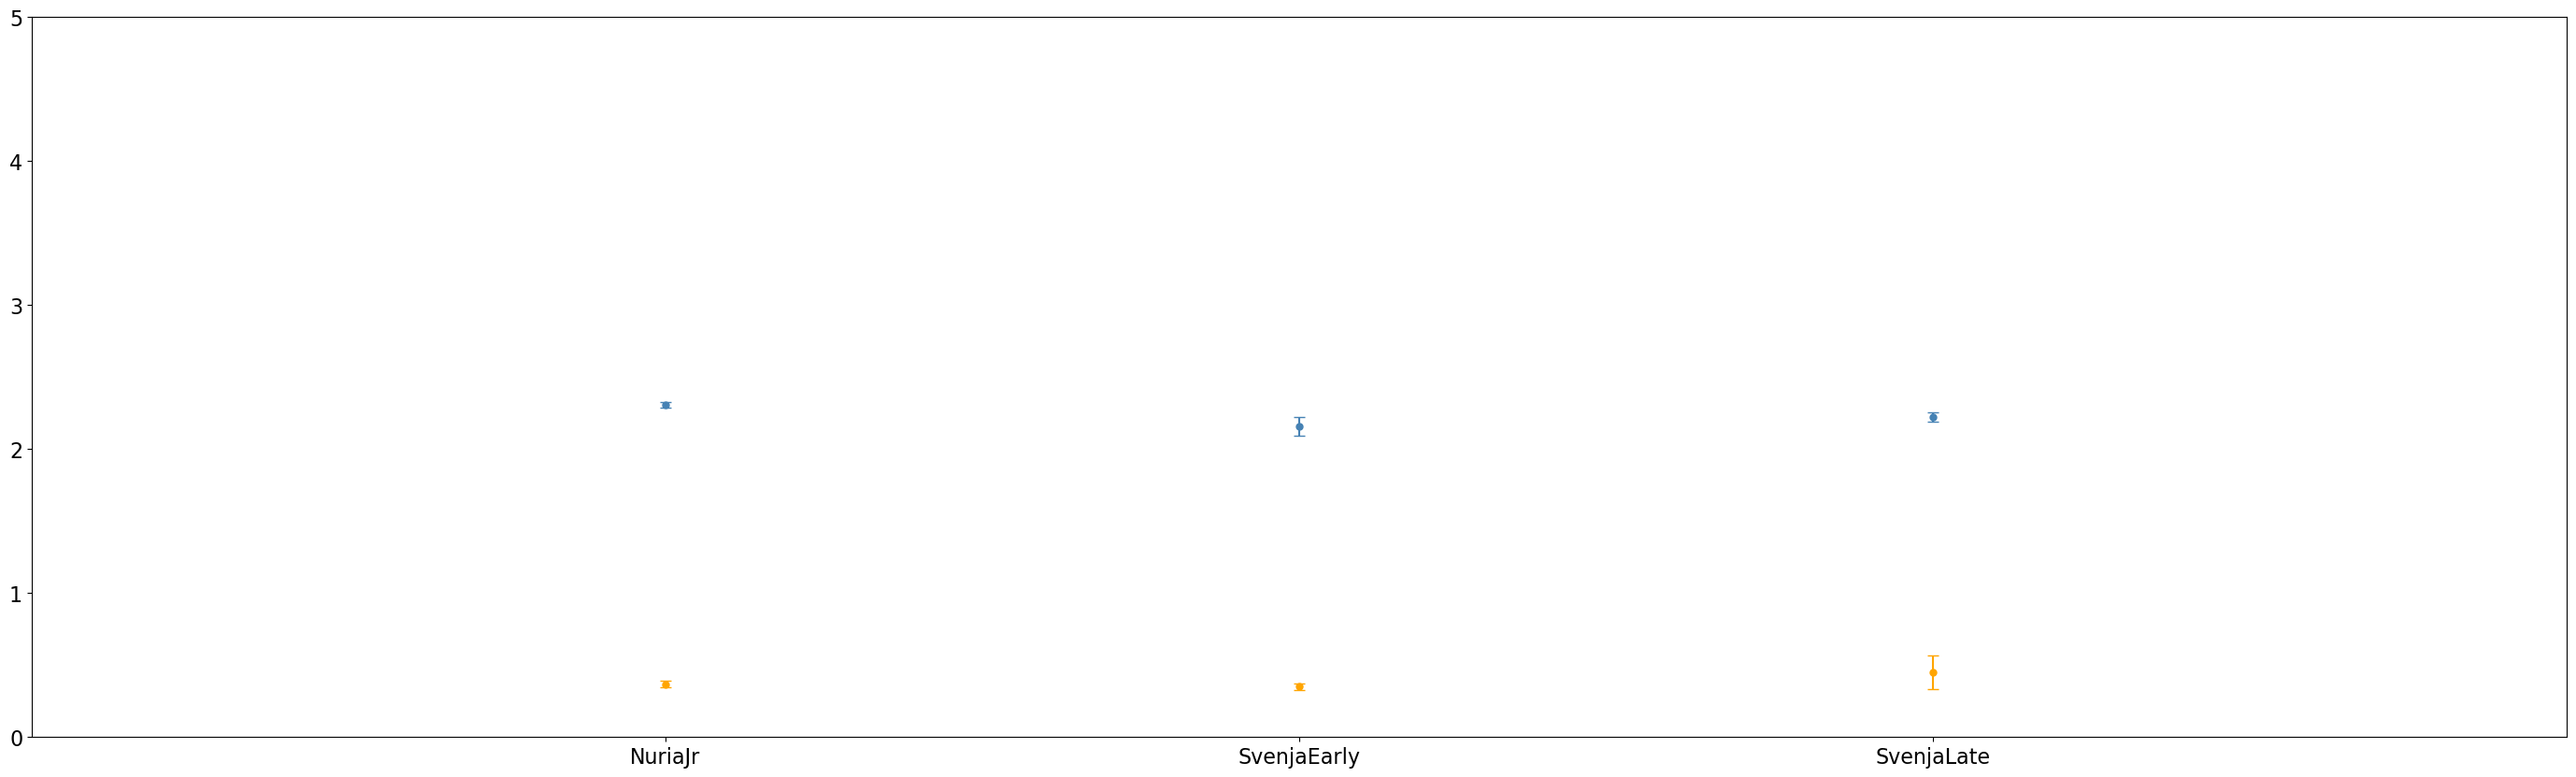

In [7]:
T1_ratios, ratios = [], []

for key, item in MIPs.items():

    if "Nuria" in key: i = 0
    # elif "Peru" in key: i = 1
    elif "NadiaEarly" in key: i = 1
    elif "NadiaLate" in key: i = 2

    if "T1" in key: 
        c="orange"
        r = T1_ratios
    else: 
        c="steelblue"
        r = ratios

    a, aerr = item[-1]
    b, berr = item[0]

    err = np.sqrt( (aerr/b)**2 + (a/b**2 * berr)**2 )
    print(key, np.round(a / b, 2), np.round(err, 3))
    r.append(item[-1][0] / item[0][0])

    plt.errorbar(i, a / b, yerr=err, c = c, markersize=5, fmt='o', capsize=4)
    plt.xticks(range(3), ["NuriaJr", "SvenjaEarly", "SvenjaLate"])
    plt.xlim(-1, 3)
    plt.ylim(0, 5)

In [18]:
print(np.mean(T1_ratios), np.std(T1_ratios) / np.mean(T1_ratios))
print(np.mean(ratios), np.std(ratios) / np.mean(ratios))

0.2749361392649326 0.03861079783493934
2.228044755280736 0.027622524682773958
